<a href="https://colab.research.google.com/github/bcury/Machine-Learning-Projects/blob/main/ML_LinearRegression_Predictions_houses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
base = pd.read_csv('/content/housing.csv')

In [6]:
base.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
base.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


In [8]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
base.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

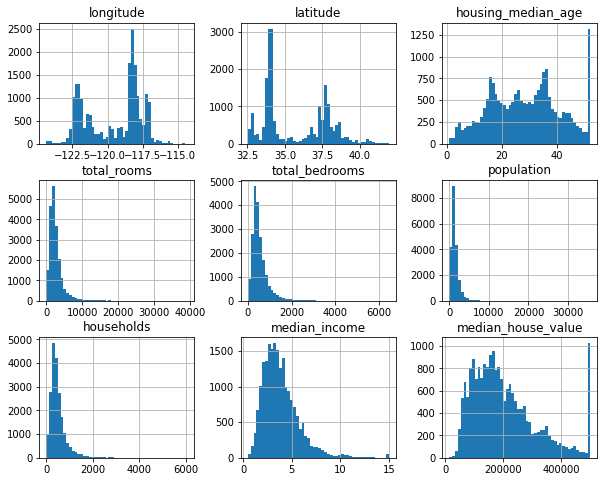

In [10]:
base.hist(bins=50, figsize=(10, 8))
plt.show()

**Treinamento do Modelo**

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
treino, teste = train_test_split(base, test_size=0.20, random_state=0)

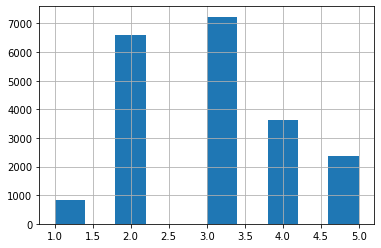

In [24]:
base['income_cat'] = pd.cut(base['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
base['income_cat'].hist()
plt.show()


In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in split.split(base, base["income_cat"]):
    strat_train_set = base.loc[train_index]
    strat_test_set = base.loc[test_index]
print(strat_test_set['income_cat'].value_counts() / len(strat_test_set))

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64


In [26]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)
base = strat_train_set.copy()

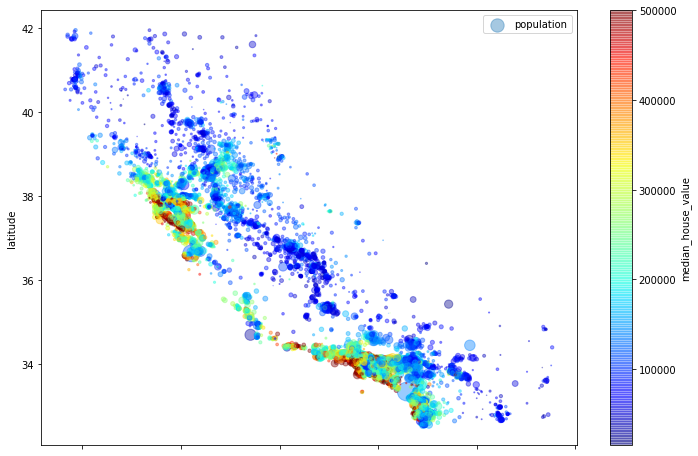

In [27]:
base.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=base['population']/100, label='population',
figsize=(12, 8), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show()

O gráfico mostra os preços das casas na Califórnia, onde o vermelho é caro, o azul é barato e os círculos maiores indicam áreas com uma população maior.

In [28]:
#correlações

In [29]:
corr_matrix = base.corr()
print(corr_matrix.median_house_value.sort_values(ascending=False))

median_house_value    1.000000
median_income         0.688988
total_rooms           0.137430
housing_median_age    0.107227
households            0.069089
total_bedrooms        0.053455
population           -0.023882
longitude            -0.042943
latitude             -0.145757
Name: median_house_value, dtype: float64


Os intervalos de correlação estão entre -1 e 1. Quando próximo de 1 significa que existe uma correlação positiva e quando está próximo de -1 significa que existe uma correlação negativa. Quando está próximo de 0, significa que não há correlação linear.

E agora vamos olhar para a matriz de correlação novamente, adicionando três novas colunas ao conjunto de dados; cômodos por domicílio, dormitórios por cômodo e população por domicílio:

In [31]:
base["rooms_per_household"] = base["total_rooms"]/base["households"]
base["bedrooms_per_room"] = base["total_bedrooms"]/base["total_rooms"]
base["population_per_household"] = base["population"]/base["households"]

corr_matrix = base.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.688988
rooms_per_household         0.157680
total_rooms                 0.137430
housing_median_age          0.107227
households                  0.069089
total_bedrooms              0.053455
population                 -0.023882
population_per_household   -0.026893
longitude                  -0.042943
latitude                   -0.145757
bedrooms_per_room          -0.255922
Name: median_house_value, dtype: float64


**Preparação dos Dados**

In [33]:
base = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

median = base["total_bedrooms"].median()
base["total_bedrooms"].fillna(median, inplace=True)

housing_num = base.drop("ocean_proximity", axis=1)

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)


In [36]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(base)

**Regressão Linear**

In [37]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [38]:
data = base.iloc[:5]
labels = housing_labels.iloc[:5]
data_preparation = full_pipeline.transform(data)
print("Predictions: ", lin_reg.predict(data_preparation))

Predictions:  [227885.17864683 199641.86684096 250266.3411042  236655.89283764
  11125.78759882]


portanto aplicando o algoritimo de Regressão Linear, prevemos os preços das casas